<a href="https://colab.research.google.com/github/YunoGr/google-colab-prototypes/blob/main/notebooks/Digit_Recognizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Digit Recognizer
This notebook implements a neural network model to recognize handwritten digits from the Kaggle Digit Recognizer competition.
https://www.kaggle.com/competitions/digit-recognizer/overview

**Author:** Pape Malick DIOP

## Importing Libraries

Here, we import the necessary libraries for our digit recognition project. These include libraries for data handling, visualization, and building our neural network with PyTorch.

In [50]:
# Data handling
import pandas as pd
import numpy as np

# Visualization tools
import torchvision
# import torchvision.transforms.v2 as transforms
import torchvision.transforms.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch kit
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, utils

## Data Loading and Initial Exploration

The datasets for this competition are stored in CSV files. We'll load them into pandas DataFrames for easy manipulation.

In [51]:
# You can load the data directly in '/data/raw/digit_recognizer'
# train_df = pd.read_csv('/data/raw/digit_recognizer/train.csv')
# test_df = pd.read_csv('/data/raw/digit_recognizer/test.csv')

But here, we mount my Google Drive to access the files.

In [52]:
from google.colab import drive

# To mount Google Drive
drive.mount('/content/drive')

project_path = "/content/drive/MyDrive/PyTorch projects/Digit Recognizer - Kaggle"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now, we load the training and test datasets from the specified path.

In [53]:
train_df = pd.read_csv(project_path + "/train.csv")
test_df = pd.read_csv(project_path + "/test.csv")

## Initial Data Exploration

Before diving into preprocessing, let's inspect the dimensions of our datasets and take a peek at the first few rows. This helps us understand the data structure and the features available.

In [54]:
print(train_df.shape)
train_df.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
print(test_df.shape)
test_df.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Data Preparation: Features and Labels

Here, we split the training data into features (the pixel values) and the target variable (the digit labels). The test data, which doesn't have labels, is assigned to a separate variable for later use in generating predictions.

In [56]:
X_train = train_df.drop('label', axis=1)
y = train_df['label']

print(X_train.shape)
print(y.shape)

(42000, 784)
(42000,)


In [57]:
X_test = test_df
print(X_test.shape)

(28000, 784)


## Data Transformations

Data transformations are crucial for image datasets, especially during training. They help in augmenting the dataset and making the model more robust to variations in the input data.

In [58]:
transforms = transforms.Compose([
    # transforms.ToTensor(),
    # transforms.Normalize((0.5,), (0.5,)),
    transforms.RandomRotation(2),
    # transforms.RandomAffine(0, translate=(0.1, 0.1)),
])

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## PyTorch Dataset and DataLoader Setup

To effectively work with our data in PyTorch and prepare it for training in batches, we define a custom Dataset class and create DataLoaders.

In [60]:
class DigitDataset(Dataset):
  def __init__(self, x_df, y_df, transform=None):
    self.xs = torch.tensor(x_df.values).float().to(device)
    self.ys = torch.tensor(y_df.values).to(device)
    self.transform = transform

  def __len__(self):
    return len(self.xs)

  def __getitem__(self, idx):
    x = self.xs[idx, :]
    x = x.reshape(28, 28)   # 784=28*28
    x = x / 255
    x = x.unsqueeze(0)
    if self.transform:
      x = self.transform(x)
    y = self.ys[idx].long()
    return x, y

In [61]:
from sklearn.model_selection import train_test_split

BATCH_SIZE = 128

X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y, test_size=0.2, random_state=42)

train_data = DigitDataset(X_train_split, y_train_split, transform=transforms)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
train_N = len(train_loader)

In [62]:
test_data = DigitDataset(X_val, y_val, transform=transforms)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)
valid_N = len(test_loader)

In [63]:
print(train_loader)
print(train_N)

263


In [64]:
print(test_loader)
print(valid_N)

66


In [65]:
batch = next(iter(train_loader))
batch

[tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],
 
 
         ...,
 
 
         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ..

In [66]:
batch[0].shape

torch.Size([128, 1, 28, 28])

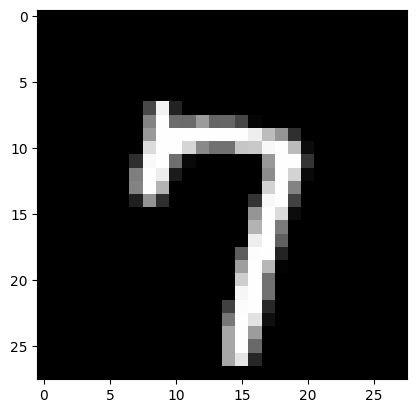

In [67]:
plt.imshow(batch[0][2, 0, :].cpu(), cmap="gray")

## Model Definition

Here, we define the architecture of our neural network models. We'll explore two different network structures: a simple Multilayer Perceptron (MLP) and a Convolutional Neural Network (CNN).

In [68]:
input_size = 28 * 28
output_size = 10

class DigitNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.flatten = nn.Flatten()
    self.layers = nn.Sequential(
        nn.Linear(input_size, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(128, output_size)
    )

  def forward(self, x):
    x = self.flatten(x)
    return self.layers(x)

In [69]:
model = DigitNetwork().to(device)
model

DigitNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)

## Training Setup

Before we can train our models, we need to define a loss function to measure how well the model is performing and an optimizer to update the model's parameters during training. We also define a helper class, `Trainer`, to handle the training and evaluation loops.

In [70]:
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [71]:
print(f"Model structure: {model}\n\n")

for name, param in model.named_parameters():
    print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")

Model structure: DigitNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)


Layer: layers.0.weight | Size: torch.Size([512, 784]) | Values : tensor([[-0.0149,  0.0141, -0.0158,  ..., -0.0165,  0.0175, -0.0260],
        [ 0.0318, -0.0013,  0.0347,  ...,  0.0054,  0.0135,  0.0136]],
       device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: layers.0.bias | Size: torch.Size([512]) | Values : tensor([-0.0294, -0.0277], device='cuda:0', grad_fn=<SliceBackward0>) 

Layer: layers.3.weight | Size: torch.Size([256, 512]) | Values : tensor([[-0.0151, -0.0137,

In [72]:
class Trainer:
  def __init__(self, model, loss_function, optimizer, train_loader, test_loader, device):
    self.model = model
    self.loss_function = loss_function
    self.optimizer = optimizer
    self.train_loader = train_loader
    self.test_loader = test_loader
    self.device = device

    self.train_losses = []
    self.train_accuracies = []
    self.test_losses = []
    self.test_accuracies = []

    self.best_loss = float('inf')
    self.patience = 5  # Number of epochs to wait before stopping
    self.min_delta = 0.001 # Minimum change to be considered an improvement
    self.counter = 0

  def get_batch_accuracy(self, output, target, batch_size):
    predictions = output.argmax(dim=1, keepdim=True)
    correct = predictions.eq(target.view_as(predictions)).sum().item()
    accuracy = correct / batch_size
    return accuracy

  def train(self):
    loss = 0
    accuracy = 0
    self.model.train()
    for x, y in self.train_loader:
      x, y = x.to(self.device), y.to(self.device)
      output = self.model(x)
      self.optimizer.zero_grad()
      batch_loss = self.loss_function(output, y)
      batch_loss.backward()
      self.optimizer.step()
      loss += batch_loss.item()
      accuracy += self.get_batch_accuracy(output, y, x.size(0)) # Use actual batch size
    self.train_losses.append(loss)
    self.train_accuracies.append(accuracy / len(self.train_loader)) # Average accuracy
    print('Train - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy / len(self.train_loader)))

  def test(self):
    loss = 0
    accuracy = 0
    self.model.eval()
    with torch.no_grad():
      for batch in self.test_loader:
        # Check if the batch contains labels
        if isinstance(batch, list) and len(batch) == 2:
            x, y = batch
            y = y.to(self.device)
            has_labels = True
        elif isinstance(batch, torch.Tensor):
            x = batch
            has_labels = False
        else:
            raise TypeError("Unsupported batch type from test_loader")

        x = x.to(self.device)
        output = self.model(x)

        if has_labels:
            loss += self.loss_function(output, y).item()
            accuracy += self.get_batch_accuracy(output, y, x.size(0)) # Use actual batch size

    if has_labels:
        self.test_losses.append(loss)
        self.test_accuracies.append(accuracy / len(self.test_loader)) # Average accuracy
        print('Valid - Loss: {:.4f} Accuracy: {:.4f}'.format(loss, accuracy / len(self.test_loader)))
        return loss
    else:
        print('Test set processed (no labels to calculate loss/accuracy)')
        return None

  def plot_curves(self):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(self.train_losses, label="Train Loss")
    plt.plot(self.test_losses, label="Test Loss")
    plt.title("Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(self.train_accuracies, label="Train Acc")
    plt.plot(self.test_accuracies, label="Test Acc")
    plt.title("Accuracy Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.show()

  def fit(self, epochs):
    for epoch in range(epochs):
      print(f"Epoch {epoch+1}\n-------------------------------")
      self.train()
      test_loss = self.test()

      # Early stopping logic
      if test_loss is not None:
          if test_loss < self.best_loss - self.min_delta:
              self.best_loss = test_loss
              self.counter = 0
          else:
              self.counter += 1
              if self.counter >= self.patience:
                  print(f"Early stopping after {epoch+1} epochs")
                  break

    print("Done!")

    return self.model

## Model Training and Evaluation

With the model, loss function, optimizer, and data loaders ready, we can now train the model. The `Trainer` class handles the training loop, iterating through epochs, calculating the loss, updating weights, and evaluating the model on the validation set.

In [73]:
trainer = Trainer(model, loss_function, optimizer, train_loader, test_loader, device)

trainer.fit(20)

Epoch 1
-------------------------------
Train - Loss: 143.8192 Accuracy: 0.8307
Valid - Loss: 12.7712 Accuracy: 0.9409
Epoch 2
-------------------------------
Train - Loss: 53.1221 Accuracy: 0.9421
Valid - Loss: 8.7172 Accuracy: 0.9603
Epoch 3
-------------------------------
Train - Loss: 38.4999 Accuracy: 0.9582
Valid - Loss: 7.2333 Accuracy: 0.9660
Epoch 4
-------------------------------
Train - Loss: 31.0273 Accuracy: 0.9654
Valid - Loss: 6.6608 Accuracy: 0.9696
Epoch 5
-------------------------------
Train - Loss: 24.5985 Accuracy: 0.9730
Valid - Loss: 6.4368 Accuracy: 0.9726
Epoch 6
-------------------------------
Train - Loss: 21.5956 Accuracy: 0.9760
Valid - Loss: 6.5943 Accuracy: 0.9717
Epoch 7
-------------------------------
Train - Loss: 18.3990 Accuracy: 0.9788
Valid - Loss: 5.7954 Accuracy: 0.9766
Epoch 8
-------------------------------
Train - Loss: 18.4594 Accuracy: 0.9795
Valid - Loss: 5.6541 Accuracy: 0.9757
Epoch 9
-------------------------------
Train - Loss: 15.8688 

DigitNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.5, inplace=False)
    (9): Linear(in_features=128, out_features=10, bias=True)
  )
)

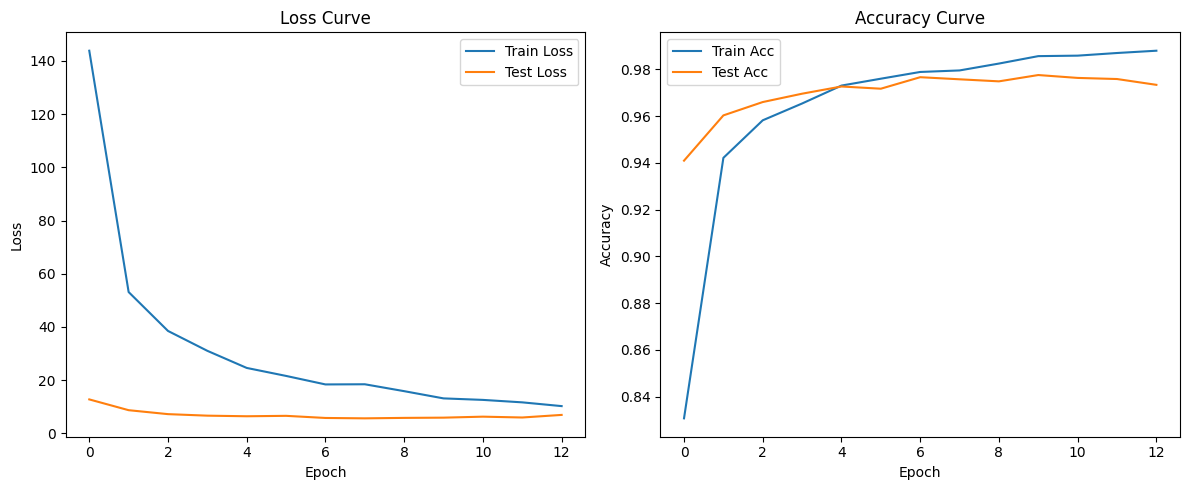

In [74]:
trainer.plot_curves()

In [75]:
kernel_size = 3
import torch.nn.functional as F_nn

class DigitNetwork2(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 64, kernel_size=kernel_size, padding=1)
    self.conv2 = nn.Conv2d(64, 128, kernel_size=kernel_size, padding=1)
    self.conv3 = nn.Conv2d(128, 128, kernel_size=kernel_size, padding=1)
    self.pool = nn.MaxPool2d(2, 2)
    self.flatten = nn.Flatten()
    self.layers = nn.Sequential(
        nn.Linear(128 * 3 * 3, 512),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, output_size)
    )

  def forward(self, x):
    x = self.pool(F_nn.relu(self.conv1(x)))
    x = self.pool(F_nn.relu(self.conv2(x)))
    x = self.pool(F_nn.relu(self.conv3(x)))
    x = self.flatten(x)
    return self.layers(x)

In [76]:
model2 = DigitNetwork2().to(device)
model2

DigitNetwork2(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=1152, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [77]:
from torchsummary import summary
summary(model2, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 28, 28]             640
         MaxPool2d-2           [-1, 64, 14, 14]               0
            Conv2d-3          [-1, 128, 14, 14]          73,856
         MaxPool2d-4            [-1, 128, 7, 7]               0
            Conv2d-5            [-1, 128, 7, 7]         147,584
         MaxPool2d-6            [-1, 128, 3, 3]               0
           Flatten-7                 [-1, 1152]               0
            Linear-8                  [-1, 512]         590,336
              ReLU-9                  [-1, 512]               0
          Dropout-10                  [-1, 512]               0
           Linear-11                  [-1, 256]         131,328
             ReLU-12                  [-1, 256]               0
          Dropout-13                  [-1, 256]               0
           Linear-14                  [

In [78]:
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()

In [79]:
trainer2 = Trainer(model2, loss_function, optimizer2, train_loader, test_loader, device)

trainer2.fit(20)

Epoch 1
-------------------------------
Train - Loss: 110.4714 Accuracy: 0.8576
Valid - Loss: 8.3713 Accuracy: 0.9625
Epoch 2
-------------------------------
Train - Loss: 21.8141 Accuracy: 0.9751
Valid - Loss: 3.5191 Accuracy: 0.9838
Epoch 3
-------------------------------
Train - Loss: 15.2131 Accuracy: 0.9818
Valid - Loss: 3.3409 Accuracy: 0.9842
Epoch 4
-------------------------------
Train - Loss: 10.8615 Accuracy: 0.9874
Valid - Loss: 3.4132 Accuracy: 0.9848
Epoch 5
-------------------------------
Train - Loss: 8.9714 Accuracy: 0.9900
Valid - Loss: 2.1270 Accuracy: 0.9895
Epoch 6
-------------------------------
Train - Loss: 7.5479 Accuracy: 0.9914
Valid - Loss: 2.8454 Accuracy: 0.9885
Epoch 7
-------------------------------
Train - Loss: 7.0084 Accuracy: 0.9918
Valid - Loss: 2.4345 Accuracy: 0.9896
Epoch 8
-------------------------------
Train - Loss: 5.4752 Accuracy: 0.9939
Valid - Loss: 2.4293 Accuracy: 0.9900
Epoch 9
-------------------------------
Train - Loss: 4.7541 Accura

DigitNetwork2(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=1152, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)

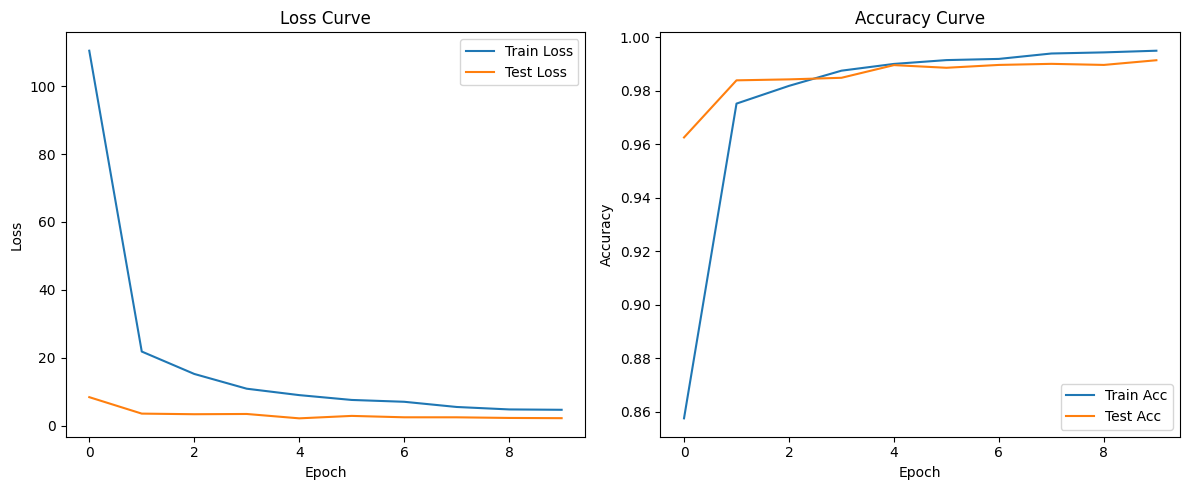

In [80]:
trainer2.plot_curves()

In [81]:
full_train_data = DigitDataset(X_train, y)
full_train_loader = DataLoader(full_train_data, batch_size=BATCH_SIZE, shuffle=True)
print(len(full_train_loader))

329


In [82]:
class TestDigitDataset(Dataset):
    def __init__(self, x_df):
        self.xs = torch.tensor(x_df.values).float().to(device)

    def __len__(self):
        return len(self.xs)

    def __getitem__(self, idx):
        x = self.xs[idx, :]
        x = x.reshape(28, 28)
        x = x / 255
        x = x.unsqueeze(0)

        return x

test_data_nolabel = TestDigitDataset(X_test)
test_loader_nolabel = DataLoader(test_data_nolabel, batch_size=BATCH_SIZE, shuffle=False)
print(len(test_loader_nolabel))

219


In [83]:
model2_full_train = DigitNetwork2().to(device)
loss_function_full_train = nn.CrossEntropyLoss()
optimizer2_full_train = optim.Adam(model2_full_train.parameters(), lr=0.001)

trainer2_full_train = Trainer(model2_full_train, loss_function_full_train, optimizer2_full_train, full_train_loader, test_loader, device)

trainer2_full_train.fit(30)

Epoch 1
-------------------------------
Train - Loss: 116.1192 Accuracy: 0.8831
Valid - Loss: 6.3833 Accuracy: 0.9719
Epoch 2
-------------------------------
Train - Loss: 24.5474 Accuracy: 0.9778
Valid - Loss: 3.7587 Accuracy: 0.9827
Epoch 3
-------------------------------
Train - Loss: 17.9482 Accuracy: 0.9844
Valid - Loss: 2.2516 Accuracy: 0.9897
Epoch 4
-------------------------------
Train - Loss: 12.2604 Accuracy: 0.9895
Valid - Loss: 1.6952 Accuracy: 0.9916
Epoch 5
-------------------------------
Train - Loss: 11.7766 Accuracy: 0.9889
Valid - Loss: 1.1142 Accuracy: 0.9941
Epoch 6
-------------------------------
Train - Loss: 8.5590 Accuracy: 0.9920
Valid - Loss: 0.8281 Accuracy: 0.9964
Epoch 7
-------------------------------
Train - Loss: 6.6735 Accuracy: 0.9940
Valid - Loss: 0.8591 Accuracy: 0.9960
Epoch 8
-------------------------------
Train - Loss: 6.7752 Accuracy: 0.9943
Valid - Loss: 1.0419 Accuracy: 0.9944
Epoch 9
-------------------------------
Train - Loss: 6.1954 Accur

DigitNetwork2(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=1152, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.3, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)

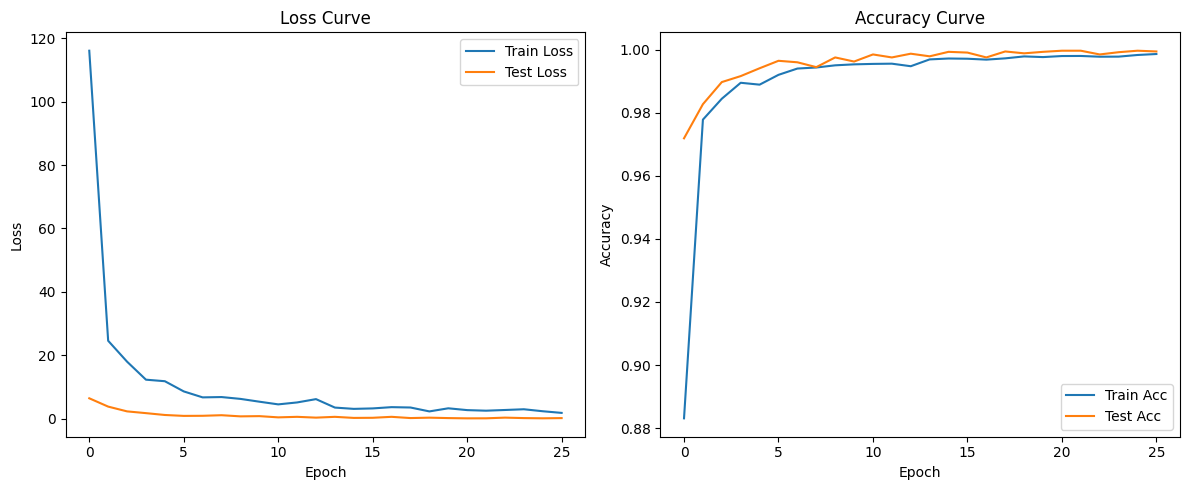

In [84]:
trainer2_full_train.plot_curves()

In [85]:
model2_full_train.eval()
predictions = []
with torch.no_grad():
    for x in test_loader_nolabel:
        x = x.to(device)
        output = model2_full_train(x)
        predicted_classes = output.argmax(dim=1)
        predictions.extend(predicted_classes.tolist())

print(len(predictions))
print(predictions[:10])

28000
[2, 0, 9, 9, 3, 7, 0, 3, 0, 3]


In [86]:
predictions[28000-5432]

1

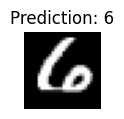

23044


In [87]:
import random

i = random.randint(0, len(predictions) - 1)
plt.figure(figsize=(1, 1))
plt.imshow(X_test.iloc[i, :].values.reshape(28, 28), cmap="gray")
plt.title(f"Prediction: {predictions[i]}")
plt.axis('off')
plt.show()
print(i)

In [88]:
submission_df = pd.DataFrame({'ImageId': range(1, len(predictions) + 1), 'Label': predictions})
submission_df.to_csv('submission.csv', index=False)

In [89]:
hyperparameter_space = {
    'learning_rate': [1e-4, 1e-3, 1e-2],
    'batch_size': [32, 64, 128],
    'num_filters_conv1': [32, 64],
    'num_filters_conv2': [64, 128],
    'num_filters_conv3': [128, 256],
    'dropout_rate_fc': [0.3, 0.5]
    }

print("Hyperparameter Search Space:")
for param, values in hyperparameter_space.items():
    print(f"- {param}: {values}")


Hyperparameter Search Space:
- learning_rate: [0.0001, 0.001, 0.01]
- batch_size: [32, 64, 128]
- num_filters_conv1: [32, 64]
- num_filters_conv2: [64, 128]
- num_filters_conv3: [128, 256]
- dropout_rate_fc: [0.3, 0.5]


In [90]:
tuning_results = []

In [ ]:
import random

class DigitNetwork2(nn.Module):
    def __init__(self, num_filters_conv1, num_filters_conv2, num_filters_conv3, dropout_rate_fc):
        super().__init__()
        self.conv1 = nn.Conv2d(1, num_filters_conv1, kernel_size=kernel_size, padding=1)
        self.conv2 = nn.Conv2d(num_filters_conv1, num_filters_conv2, kernel_size=kernel_size, padding=1)
        self.conv3 = nn.Conv2d(num_filters_conv2, num_filters_conv3, kernel_size=kernel_size, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.flatten = nn.Flatten()

        # Calculate the size of the flattened output after convolutional and pooling layers
        # We can do a forward pass with a dummy tensor to determine this size
        dummy_input = torch.randn(1, 1, 28, 28)
        dummy_output = self.pool(F_nn.relu(self.conv1(dummy_input)))
        dummy_output = self.pool(F_nn.relu(self.conv2(dummy_output)))
        dummy_output = self.pool(F_nn.relu(self.conv3(dummy_output)))
        flattened_size = self.flatten(dummy_output).size(1)

        self.layers = nn.Sequential(
            nn.Linear(flattened_size, 512),
            nn.ReLU(),
            nn.Dropout(dropout_rate_fc),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate_fc),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        x = self.pool(F_nn.relu(self.conv1(x)))
        x = self.pool(F_nn.relu(self.conv2(x)))
        x = self.pool(F_nn.relu(self.conv3(x)))
        x = self.flatten(x)
        return self.layers(x)

In [91]:
num_tuning_trials = 5
tuning_results = []
epochs_for_tuning = 5

for trial in range(num_tuning_trials):
    print(f"Starting tuning trial {trial + 1}/{num_tuning_trials}")

    # Sample hyperparameters
    sampled_lr = random.choice(hyperparameter_space['learning_rate'])
    sampled_batch_size = random.choice(hyperparameter_space['batch_size'])
    sampled_num_filters_conv1 = random.choice(hyperparameter_space['num_filters_conv1'])
    sampled_num_filters_conv2 = random.choice(hyperparameter_space['num_filters_conv2'])
    sampled_num_filters_conv3 = random.choice(hyperparameter_space['num_filters_conv3'])
    sampled_dropout_rate_fc = random.choice(hyperparameter_space['dropout_rate_fc'])

    print(f"  Hyperparameters: LR={sampled_lr}, Batch Size={sampled_batch_size}, Filters_conv1={sampled_num_filters_conv1}, Filters_conv2={sampled_num_filters_conv2}, Filters_conv3={sampled_num_filters_conv3}, Dropout={sampled_dropout_rate_fc}")

    train_data_tuned = DigitDataset(X_train_split, y_train_split, transform=transforms)
    train_loader_tuned = DataLoader(train_data_tuned, batch_size=sampled_batch_size, shuffle=True)

    test_data_tuned = DigitDataset(X_val, y_val, transform=transforms) # Validation set
    test_loader_tuned = DataLoader(test_data_tuned, batch_size=sampled_batch_size, shuffle=False)


    model_tuned = DigitNetwork2(
        num_filters_conv1=sampled_num_filters_conv1,
        num_filters_conv2=sampled_num_filters_conv2,
        num_filters_conv3=sampled_num_filters_conv3,
        dropout_rate_fc=sampled_dropout_rate_fc
    ).to(device)

    loss_function_tuned = nn.CrossEntropyLoss()
    optimizer_tuned = optim.Adam(model_tuned.parameters(), lr=sampled_lr)

    # Trainer instance
    trainer_tuned = Trainer(model_tuned, loss_function_tuned, optimizer_tuned, train_loader_tuned, test_loader_tuned, device)
    trainer_tuned.fit(epochs_for_tuning)

    # Evaluate on validation set
    validation_loss = trainer_tuned.test()
    validation_accuracy = trainer_tuned.test_accuracies[-1]

    print(f"  Trial {trial + 1} Results: Validation Loss={validation_loss:.4f}, Validation Accuracy={validation_accuracy:.4f}\n")

    # Store results
    tuning_results.append({
        'trial': trial + 1,
        'learning_rate': sampled_lr,
        'batch_size': sampled_batch_size,
        'num_filters_conv1': sampled_num_filters_conv1,
        'num_filters_conv2': sampled_num_filters_conv2,
        'num_filters_conv3': sampled_num_filters_conv3,
        'dropout_rate_fc': sampled_dropout_rate_fc,
        'validation_loss': validation_loss,
        'validation_accuracy': validation_accuracy
    })

print("Hyperparameter tuning completed.")

Starting tuning trial 1/5
  Hyperparameters: LR=0.001, Batch Size=32, Filters_conv1=64, Filters_conv2=64, Filters_conv3=128, Dropout=0.3
Epoch 1
-------------------------------
Train - Loss: 318.3907 Accuracy: 0.8995
Valid - Loss: 25.0137 Accuracy: 0.9741
Epoch 2
-------------------------------
Train - Loss: 83.6123 Accuracy: 0.9781
Valid - Loss: 14.7234 Accuracy: 0.9840
Epoch 3
-------------------------------
Train - Loss: 58.6887 Accuracy: 0.9843
Valid - Loss: 14.0265 Accuracy: 0.9874
Epoch 4
-------------------------------
Train - Loss: 49.1591 Accuracy: 0.9869
Valid - Loss: 15.9199 Accuracy: 0.9825
Epoch 5
-------------------------------
Train - Loss: 42.4809 Accuracy: 0.9885
Valid - Loss: 11.0795 Accuracy: 0.9881
Done!
Valid - Loss: 11.0795 Accuracy: 0.9881
  Trial 1 Results: Validation Loss=11.0795, Validation Accuracy=0.9881

Starting tuning trial 2/5
  Hyperparameters: LR=0.0001, Batch Size=64, Filters_conv1=32, Filters_conv2=64, Filters_conv3=128, Dropout=0.5
Epoch 1
---------

In [92]:
# Analyze the tuning results to find the best hyperparameters
best_trial = None
best_accuracy = -1
best_loss = float('inf')

for result in tuning_results:
    print(f"Trial {result['trial']}: Validation Accuracy = {result['validation_accuracy']:.4f}, Validation Loss = {result['validation_loss']:.4f}")
    if result['validation_accuracy'] > best_accuracy:
        best_accuracy = result['validation_accuracy']
        best_trial = result
    elif result['validation_accuracy'] == best_accuracy and result['validation_loss'] < best_loss:
        best_loss = result['validation_loss']
        best_trial = result

print("\nBest performing hyperparameters based on validation accuracy:")
print(f"Trial: {best_trial['trial']}")
print(f"Learning Rate: {best_trial['learning_rate']}")
print(f"Batch Size: {best_trial['batch_size']}")
print(f"Num Filters Conv1: {best_trial['num_filters_conv1']}")
print(f"Num Filters Conv2: {best_trial['num_filters_conv2']}")
print(f"Num Filters Conv3: {best_trial['num_filters_conv3']}")
print(f"Dropout Rate FC: {best_trial['dropout_rate_fc']}")
print(f"Validation Accuracy: {best_trial['validation_accuracy']:.4f}")
print(f"Validation Loss: {best_trial['validation_loss']:.4f}")

Trial 1: Validation Accuracy = 0.9881, Validation Loss = 11.0795
Trial 2: Validation Accuracy = 0.9747, Validation Loss = 10.4356
Trial 3: Validation Accuracy = 0.9682, Validation Loss = 6.9837
Trial 4: Validation Accuracy = 0.9879, Validation Loss = 2.6272
Trial 5: Validation Accuracy = 0.9895, Validation Loss = 10.6137

Best performing hyperparameters based on validation accuracy:
Trial: 5
Learning Rate: 0.001
Batch Size: 32
Num Filters Conv1: 64
Num Filters Conv2: 128
Num Filters Conv3: 128
Dropout Rate FC: 0.5
Validation Accuracy: 0.9895
Validation Loss: 10.6137


In [93]:
# Create data loaders with the best batch size
best_batch_size = best_trial['batch_size']

full_train_data_final = DigitDataset(X_train, y, transform=transforms)
full_train_loader_final = DataLoader(full_train_data_final, batch_size=best_batch_size, shuffle=True)

test_data_final = DigitDataset(X_val, y_val, transform=transforms) # Validation set
test_loader_final = DataLoader(test_data_final, batch_size=best_batch_size, shuffle=False)


# Create model, loss function, and optimizer with best hyperparameters
model_final = DigitNetwork2(
    num_filters_conv1=best_trial['num_filters_conv1'],
    num_filters_conv2=best_trial['num_filters_conv2'],
    num_filters_conv3=best_trial['num_filters_conv3'],
    dropout_rate_fc=best_trial['dropout_rate_fc']
).to(device)

loss_function_final = nn.CrossEntropyLoss()
optimizer_final = optim.Adam(model_final.parameters(), lr=best_trial['learning_rate'])

trainer_final = Trainer(model_final, loss_function_final, optimizer_final, full_train_loader_final, test_loader_final, device)
trainer_final.fit(30)

Epoch 1
-------------------------------
Train - Loss: 420.7381 Accuracy: 0.8964
Valid - Loss: 16.5512 Accuracy: 0.9825
Epoch 2
-------------------------------
Train - Loss: 110.3100 Accuracy: 0.9782
Valid - Loss: 10.0384 Accuracy: 0.9891
Epoch 3
-------------------------------
Train - Loss: 79.9653 Accuracy: 0.9838
Valid - Loss: 12.5729 Accuracy: 0.9870
Epoch 4
-------------------------------
Train - Loss: 67.8914 Accuracy: 0.9866
Valid - Loss: 8.7369 Accuracy: 0.9899
Epoch 5
-------------------------------
Train - Loss: 59.7128 Accuracy: 0.9883
Valid - Loss: 5.9469 Accuracy: 0.9944
Epoch 6
-------------------------------
Train - Loss: 43.4131 Accuracy: 0.9907
Valid - Loss: 3.0769 Accuracy: 0.9968
Epoch 7
-------------------------------
Train - Loss: 41.7799 Accuracy: 0.9915
Valid - Loss: 3.3570 Accuracy: 0.9966
Epoch 8
-------------------------------
Train - Loss: 42.6344 Accuracy: 0.9917
Valid - Loss: 2.6740 Accuracy: 0.9976
Epoch 9
-------------------------------
Train - Loss: 37.76

DigitNetwork2(
  (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layers): Sequential(
    (0): Linear(in_features=1152, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=512, out_features=256, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.5, inplace=False)
    (6): Linear(in_features=256, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=10, bias=True)
  )
)

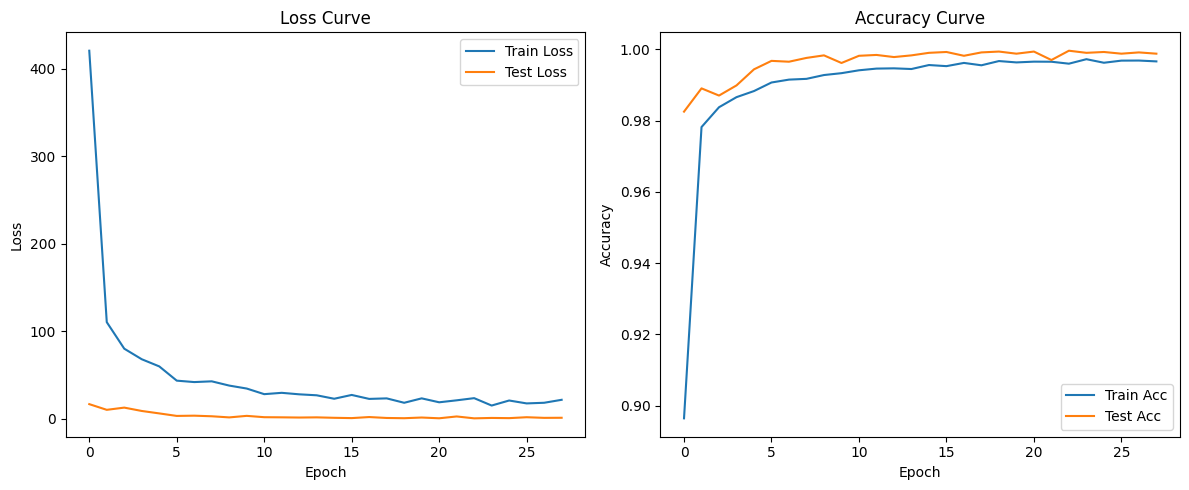

In [94]:
trainer_final.plot_curves()

In [95]:
model_final.eval()
predictions = []
with torch.no_grad():
    for batch in test_loader_final:
        x = batch[0].to(device)
        output = model_final(x)
        predicted_classes = output.argmax(dim=1)
        predictions.extend(predicted_classes.tolist())

print(len(predictions))
print(predictions[:10])

8400
[8, 1, 9, 9, 8, 6, 2, 2, 7, 1]


In [96]:
model_final.eval()
predictions = []
with torch.no_grad():
    for x in test_loader_nolabel:
        x = x.to(device)
        output = model_final(x)
        predicted_classes = output.argmax(dim=1)
        predictions.extend(predicted_classes.tolist())

print(len(predictions))
print(predictions[:10])

28000
[2, 0, 9, 9, 3, 7, 0, 3, 0, 3]


In [97]:
len(predictions)

28000

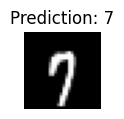

1001


In [98]:
i = random.randint(0, len(predictions) - 1)
plt.figure(figsize=(1, 1))
plt.imshow(X_test.iloc[i, :].values.reshape(28, 28), cmap="gray")
plt.title(f"Prediction: {predictions[i]}")
plt.axis('off')
plt.show()
print(i)

In [99]:
# Submission
submission_df = pd.DataFrame({'ImageId': range(1, len(predictions) + 1), 'Label': predictions})
submission_df.to_csv('submission.csv', index=False)